## Initialization

In [1]:
import os
import sys
from datetime import datetime

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split

import matplotlib.pyplot as plt
from tqdm import tqdm

root_dir = os.getcwd().split("AdversarialNIDS")[0] + "AdversarialNIDS"
sys.path.append(root_dir)

from scripts.logger import LoggerManager
from scripts.analysis.model_analysis import perform_model_analysis

from CICIDS2017.preprocessing.dataset import CICIDS2017
from UNSWNB15.preprocessing.dataset import UNSWNB15

from scripts.models.pytorch.MLP import NetworkIntrusionMLP
from scripts.models.pytorch.CNN import NetworkIntrustionCNN
from scripts.models.pytorch.LSTM import NetworkIntrusionLSTM

from scripts.models.pytorch.train import train
from scripts.models.pytorch.visualization import display_loss

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

lm = LoggerManager(
    log_dir=f"{root_dir}/results/logs",
    log_name="TDM",
)
logger = lm.get_logger()
title = lm.get_title()
logger.info(f"Logger initialized for '{title}'")
logger.info(f"Using device: {device}")

2025-11-21 20:13:18,394 - INFO - Logger initialized for 'TDM_20251121_201318'
2025-11-21 20:13:18,395 - INFO - Using device: cuda:0


## Initialization of the Dataset

In [ ]:
full_dataset = CICIDS2017( # [UNSWNB15() or CICIDS2017()]
    dataset_size="small",
    logger=logger
).optimize_memory().encode(attack_encoder="label").scale(scaler="minmax")

2025-11-21 20:13:18,401 - INFO - Downloading dataset: mrwellsdavid/unsw-nb15
2025-11-21 20:13:23,221 - INFO - Loaded UNSW-NB15_1.csv with shape: (700000, 46)
2025-11-21 20:13:23,222 - INFO - DataFrame shape: (700000, 46)
2025-11-21 20:13:23,223 - INFO - Initial dimensions: 700,000 rows x 46 columns = 32,200,000 cells
2025-11-21 20:13:26,553 - INFO - ============================================================
2025-11-21 20:13:26,553 - INFO - Preprocessing completed successfully
2025-11-21 20:13:26,554 - INFO - Final dimensions: 640,658 rows x 46 columns
2025-11-21 20:13:26,554 - INFO - Total rows removed: 59,342 (8.48%)
2025-11-21 20:13:26,554 - INFO - data retention rate: 91.52%
2025-11-21 20:13:26,555 - INFO - ============================================================
2025-11-21 20:13:26,648 - INFO - Optimizing memory usage of the dataset...
2025-11-21 20:13:26,651 - INFO - Initial memory usage: 229.73 MB
2025-11-21 20:13:26,779 - INFO - Optimized memory usage: 136.86 MB
2025-11-21

In [3]:
full_dataset.distribution(full_dataset.attack_classes)

2025-11-21 20:13:28,011 - INFO - Calculating data distribution...
2025-11-21 20:13:28,018 - INFO - Data Distribution by Attack Type:
2025-11-21 20:13:28,019 - INFO -   3: 626,380 instances
2025-11-21 20:13:28,019 - INFO -   5: 4,042 instances
2025-11-21 20:13:28,020 - INFO -   0: 3,991 instances
2025-11-21 20:13:28,020 - INFO -   6: 2,833 instances
2025-11-21 20:13:28,020 - INFO -   7: 1,740 instances
2025-11-21 20:13:28,020 - INFO -   4: 825 instances
2025-11-21 20:13:28,021 - INFO -   1: 301 instances
2025-11-21 20:13:28,021 - INFO -   2: 299 instances
2025-11-21 20:13:28,022 - INFO -   8: 223 instances
2025-11-21 20:13:28,022 - INFO -   9: 24 instances


3    626380
5      4042
0      3991
6      2833
7      1740
4       825
1       301
2       299
8       223
9        24
Name: count, dtype: int64

In [4]:
dataset, multi_class = full_dataset.subset(size=50000, multi_class=False)

2025-11-21 20:13:28,031 - INFO - Subsetting dataset to size: 50000...
2025-11-21 20:13:28,035 - INFO - Class distribution before subsetting:
2025-11-21 20:13:28,036 - INFO -   Class 0: 626380 samples
2025-11-21 20:13:28,037 - INFO -   Class 1: 14278 samples
2025-11-21 20:13:28,058 - INFO - Subsetted dataset to size: 39278


In [5]:
dataset.distribution(dataset.attack_classes if multi_class else dataset.is_attack)

2025-11-21 20:13:28,096 - INFO - Calculating data distribution...
2025-11-21 20:13:28,098 - INFO - Data Distribution by Attack Type:
2025-11-21 20:13:28,099 - INFO -   0: 25,000 instances
2025-11-21 20:13:28,100 - INFO -   1: 14,278 instances


0    25000
1    14278
Name: count, dtype: int64

In [6]:
X_train, X_val, y_train, y_val = dataset.split(
    one_hot=True,
    apply_smote=True,
    to_tensor=True
)

2025-11-21 20:13:28,109 - INFO - Splitting dataset into training and testing sets...
2025-11-21 20:13:28,131 - INFO - Class distribution before SMOTE:
2025-11-21 20:13:28,319 - INFO - Applied SMOTE to balance the training set.
2025-11-21 20:13:28,321 - INFO - Class distribution after SMOTE:
2025-11-21 20:13:28,322 - INFO -   Class 0.0: 19917 samples
2025-11-21 20:13:28,322 - INFO -   Class 1.0: 19917 samples


In [7]:
# Create DataLoaders
train_dataset = TensorDataset(X_train.to(device), y_train.to(device))
val_dataset = TensorDataset(X_val.to(device), y_val.to(device))

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [8]:
input_size = train_loader.dataset.tensors[0].shape[1]
num_classes = train_loader.dataset.tensors[1].shape[1]
print(f"Input size: {input_size}, Num classes: {num_classes}")

model_type = f"{input_size}x{num_classes}"

criterion = nn.CrossEntropyLoss() if multi_class else nn.BCELoss()

Input size: 45, Num classes: 2


## Multi Layers Perceptron (MLP)

In [9]:
model_mlp = NetworkIntrusionMLP(input_size=input_size, num_classes=num_classes).to(device)
logger.info(f"MLP Model initialized with {model_mlp.num_params()} parameters")

learning_rate_mlp = 1e-2
num_epochs_mlp = 100

mlp_title = f"MLP_{model_type}_{num_epochs_mlp}"

optimizer_mlp = optim.AdamW(model_mlp.parameters(), lr=learning_rate_mlp)
scheduler_mlp = optim.lr_scheduler.ReduceLROnPlateau(optimizer_mlp, mode='min', factor=0.8, patience=10, min_lr=1e-6)

2025-11-21 20:13:28,510 - INFO - MLP Model initialized with 17234 parameters


In [10]:
model_mlp, train_losses_mlp, val_losses_mlp = train(
    model=model_mlp,
    optimizer=optimizer_mlp,
    scheduler=scheduler_mlp,
    criterion=criterion,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=num_epochs_mlp,
    title=mlp_title,
    dir=f"{root_dir}/results/weights",
    logger=logger,
    device=device,
)

Loss: 0.0137, Val Loss: 0.0143, LR: 0.010000: 100%|██████████| 100/100 [01:32<00:00,  1.09it/s]


2025-11-21 20:15:01,616 - INFO - Plotting loss curve...
2025-11-21 20:15:02,388 - INFO - Loss curve saved as /media/alexin/MStock/Documents/Cours/TelecomSE/FISE2/Semestre 7/Projet/AdversarialNIDS/results/plots/loss_img/TDM_20251121_201318_MLP_45x2_100_loss.png


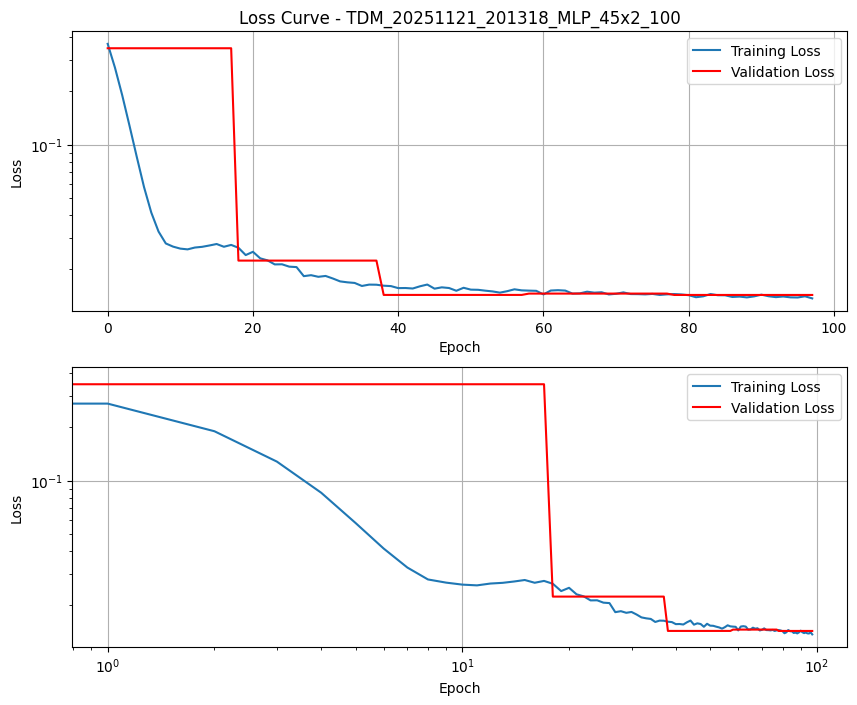

In [11]:
display_loss(
    list_epoch_loss=train_losses_mlp,
    list_val_loss=val_losses_mlp,
    title=f"{title}_{mlp_title}",
    dir=f"{root_dir}/results/plots",
    plot=True,
    logger=logger,
    epoch_min=2
)

2025-11-21 20:16:31,720 - INFO - Running analysis for PyTorch model: TDM_20251121_201318_MLP_45x2_100 on device: cuda:0


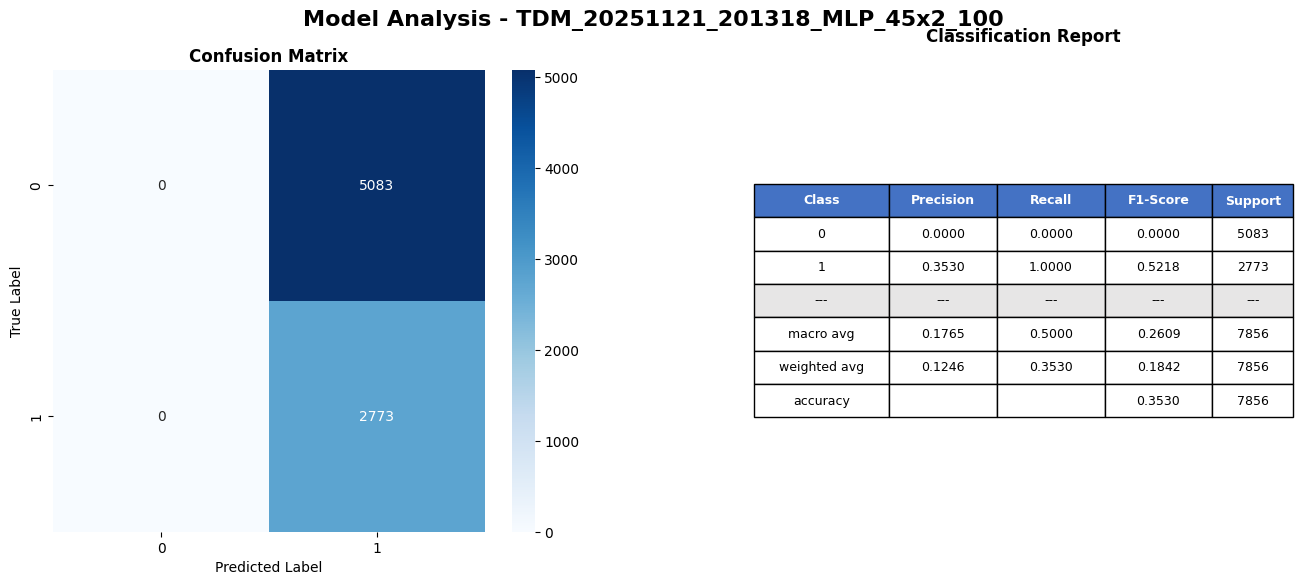

In [13]:
cm, cr = perform_model_analysis(
    model=model_mlp,
    X_test=X_val,
    y_test=y_val,
    logger=logger,
    model_name=f"{title}_{mlp_title}",
    dir=f"{root_dir}/results/analysis",
    plot=True,
    device=device
)

model_mlp = model_mlp.cpu()

## Convolutional Neural Network (CNN)

In [ ]:
model_cnn = NetworkIntrustionCNN(input_channels=1, input_size= input_size, num_classes=num_classes).to(device)
logger.info(f"CNN Model initialized with {model_cnn.num_params()} parameters")

learning_rate_cnn = 1e-2
num_epochs_cnn = 100

cnn_title = f"CNN_{model_type}_{num_epochs_cnn}"

optimizer_cnn = optim.AdamW(model_cnn.parameters(), lr=learning_rate_cnn)
scheduler_cnn = optim.lr_scheduler.ReduceLROnPlateau(optimizer_cnn, mode='min', factor=0.8, patience=10, min_lr=1e-6)

In [ ]:
model_cnn, train_loss_cnn, val_loss_cnn = train(
    model=model_cnn,
    optimizer=optimizer_cnn,
    scheduler=scheduler_cnn,
    criterion=criterion,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=num_epochs_cnn,
    title=cnn_title,
    dir=f"{root_dir}/results/weights",
    logger=logger,
    device=device,
)

In [ ]:
display_loss(
    train_loss_cnn,
    val_loss_cnn,
    title=f"{title}_{cnn_title}",
    dir=f"{root_dir}/results/plots",
    plot=True,
    logger=logger,
    epoch_min=2
)

In [ ]:
cm, cr = perform_model_analysis(
    model=model_cnn,
    X_test=X_val,
    y_test=y_val,
    model_name=f"{title}_{cnn_title}",
    dir=f"{root_dir}/results/analysis",
    plot=True,
    logger=logger,
    device=device
)

model_cnn = model_cnn.cpu()

## Long Short-Term Memory (LSTM)

In [ ]:
model_lstm = NetworkIntrusionLSTM(input_size=input_size, hidden_size=32, num_layers=2, num_classes=num_classes).to(device)
logger.info(f"LSTM Model initialized with {model_lstm.num_params()} parameters")

learning_rate_lstm = 1e-2
num_epochs_lstm = 100

lstm_title = f"LSTM_{model_type}_{num_epochs_lstm}"

optimizer_lstm = optim.AdamW(model_lstm.parameters(), lr=learning_rate_lstm)
scheduler_lstm = optim.lr_scheduler.ReduceLROnPlateau(optimizer_lstm, mode='min', factor=0.8, patience=10, min_lr=1e-6)

In [ ]:
model_lstm, train_loss_lstm, val_loss_lstm = train(
    model=model_lstm,
    optimizer=optimizer_lstm,
    scheduler=scheduler_lstm,
    criterion=criterion,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=num_epochs_lstm,
    title=lstm_title,
    dir=f"{root_dir}/results/weights",
    logger=logger,
    device=device,
)

In [ ]:
display_loss(
    train_loss_lstm, 
    val_loss_lstm, 
    title=f"{title}_{lstm_title}",
    dir=f"{root_dir}/results/plots",
    plot=True,
    logger=logger,
    epoch_min=2
)

In [ ]:
cm, cr = perform_model_analysis(
    model=model_lstm,
    X_test=X_val,
    y_test=y_val,
    model_name=f"{title}_{lstm_title}",
    dir=f"{root_dir}/results/analysis",
    plot=True,
    logger=logger,
    device=device
)

# Move model to CPU to free up GPU memory
model_lstm = model_lstm.cpu()